In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
from pkg.utils import *
gtimer = GlobalTimer.instance()

In [2]:
import rospy
rospy.init_node('indy_test', anonymous=True)
rate = rospy.Rate(100)

# Indy funcs

In [4]:
from functools import wraps

def connect_indy(func):
    @wraps(func)
    def __wrapper(indy, *args, **kwargs):
        connect = kwargs["connect"] if "connect" in kwargs else False
        if connect: indy.connect()
        res = func(indy, *args, **kwargs)
        if connect: indy.disconnect()
        return res
    return __wrapper

@connect_indy
def indy_wait_motion(indy, period=1e-1):
    while not indy.get_robot_status()['movedone']:
        time.sleep(period)
        
@connect_indy
def indy_joint_move_make_sure(indy, Q, N_makesure=5): 
    for _ in range(N_makesure):
        indy.joint_move_to(Q)
        indy_wait_motion(indy)

# Prepare indy

In [5]:
from indy_utils import indydcp_client as client

robot_ip = "192.168.0.63"  # Robot (Indy) IP
robot_name = "NRMK-Indy7"  # Robot name (Indy7)
# robot_name = "NRMK-IndyRP2"  # Robot name (IndyRP2)

# Create class object
indy = client.IndyDCPClient(robot_ip, robot_name)

indy.connect()
indy.set_collision_level(5)
indy.set_joint_vel_level(3)
indy.set_task_vel_level(3)
indy.set_joint_blend_radius(20)
indy.set_task_blend_radius(0.2)

print(indy.get_collision_level())
print(indy.get_joint_vel_level())
print(indy.get_task_vel_level())
print(indy.get_joint_blend_radius())
print(indy.get_task_blend_radius())


indy.stop_motion()

indy.disconnect()

Connect: Server IP (192.168.0.63)
5
3
3
20.0
0.2


# Prepare panda

In [6]:
from pkg.panda_repeater import *
PANDA_DOF = 7
panda = PandaRepeater()

# Define indy tracking funcs

In [7]:
INDY_DOF = 6
PORT_REPEATER = 1189
INDY_CONTROL_FREQ = 4000
TRAJECTORY_FREQ = 100

@connect_indy
def indy_init_online_tracking(indy, q0, traj_freq=TRAJECTORY_FREQ):
    indy.move_ext_traj_txt(traj_type=1, traj_freq=INDY_CONTROL_FREQ, dat_size=INDY_DOF,
                                 traj_data=q0.tolist()+[0]*2*INDY_DOF)
    return send_recv({'reset': True, 'period_s': 1.0/traj_freq, 'qcur': q0},
                     indy.server_ip, PORT_REPEATER)

@connect_indy
def indy_send_track_q(indy, Q):
    return send_recv({'qval': Q}, indy.server_ip, PORT_REPEATER)

@connect_indy
def indy_stop_online_tracking(indy):
    send_recv({'stop': True}, indy.server_ip, PORT_REPEATER)
    indy.stop_motion()

# Test indy tracking

[ 0. -0. -0.  0. -0.  0.]
[ 0. -0. -0.  0. -0.  0.]
[0. 0. 0. 0. 0. 0.]


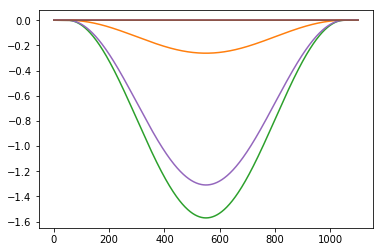

In [8]:
# Prepare path

N_t = 1000
PORT_REPEATER = 1189

MAG = 1#np.deg2rad(5)
e_POS = np.deg2rad([[0, -15, -90, 0, -75, 0]])*np.transpose([MAG*((np.sin(np.pi*(np.arange(N_t+1)*2-N_t/2)/N_t)+1)/2)])
e_POS = np.pad(e_POS, [[50,50],[0,0]],'edge')
plt.plot(e_POS)
print(e_POS[0])
print(e_POS[-1])
print(e_POS[0]-e_POS[-1])

In [9]:
# test init stop
indy.connect()
indy_joint_move_make_sure(indy, e_POS[0])
indy_init_online_tracking(indy, e_POS[0], TRAJECTORY_FREQ)
indy_stop_online_tracking(indy)
indy.disconnect()

Connect: Server IP (192.168.0.63)


In [10]:
gtimer.reset()

indy.connect()
indy_joint_move_make_sure(indy, e_POS[0])
indy_init_online_tracking(indy, e_POS[0], TRAJECTORY_FREQ)

qcount = 0
qcount_indy_list = []
looptime_list = []
networktime_list = []
for Q in e_POS:
    gtimer.tic("loop")
    Q_indy = Q#[0]*6
    while(qcount>=3):
        qcount -= 1
        rate.sleep()
    gtimer.tic("send_recv")
    qcount_indy=indy_send_track_q(indy, Q_indy)['qcount']    
    networktime_list.append(gtimer.toc("send_recv"))
    qcount = qcount_indy
    qcount_indy_list.append(qcount_indy)
    looptime_list.append(gtimer.toc("loop"))
    
indy_stop_online_tracking(indy)
indy.disconnect()

Connect: Server IP (192.168.0.63)


loop: 	10976.0 ms/1101 = 9.969 ms (1.076/19.912)
send_recv: 	1511.0 ms/1101 = 1.372 ms (0.805/2.065)



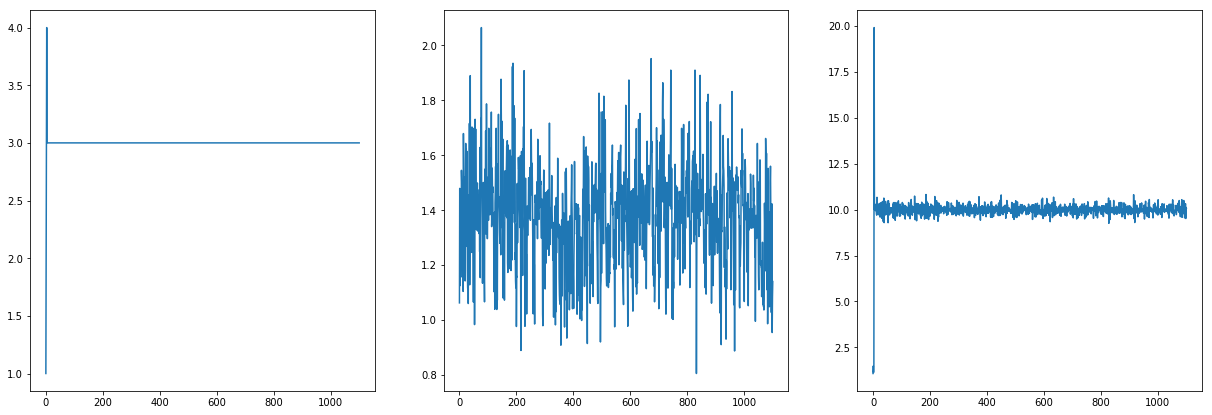

In [11]:
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
ax = plt.plot(qcount_indy_list)
plt.subplot(1,3,2)
ax = plt.plot(networktime_list)
plt.subplot(1,3,3)
ax = plt.plot(looptime_list)
print(gtimer)

# Test panda

In [12]:
Q0_panda = panda.get_qcur()

[-0.99004225 -1.16020587 -0.09935153 -1.08413537  0.28192717  1.8495644
 -2.16893122]
[-0.99004225 -1.16020587 -0.09935153 -1.08413537  0.28192717  1.8495644
 -2.16893122]
[0. 0. 0. 0. 0. 0. 0.]


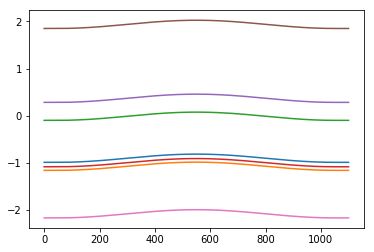

In [13]:
# Prepare path

N_t = 1000
PORT_REPEATER = 1189

MAG = 1#np.deg2rad(5)
e_POS = np.deg2rad([[10]*PANDA_DOF])*np.transpose([MAG*((np.sin(np.pi*(np.arange(N_t+1)*2-N_t/2)/N_t)+1)/2)])
e_POS = Q0_panda+np.pad(e_POS, [[50,50],[0,0]],'edge')
plt.plot(e_POS)
print(e_POS[0])
print(e_POS[-1])
print(e_POS[0]-e_POS[-1])

In [14]:
gtimer.reset()
panda.reset()

qcount_panda_list = []
looptime_list = []
networktime_list = []
for Q in e_POS:
    gtimer.tic("loop")
    Q_panda = Q
    #while(qcount>=3):
    #    qcount -= 1
    #    rate.sleep()
    if qcount>=3:
        rate.sleep()
    gtimer.tic("send_recv")
    if qcount>3:
        qcount_panda = panda.get_qcount()
    else:
        qcount_panda = panda.send_qval(Q_panda)['qcount']
    networktime_list.append(gtimer.toc("send_recv"))
    qcount = qcount_panda
    qcount_panda_list.append(qcount_panda)
    looptime_list.append(gtimer.toc("loop"))
panda.stop_tracking()

{'stop': True}

loop: 	10831.0 ms/1101 = 9.838 ms (0.997/10.926)
send_recv: 	1660.0 ms/1101 = 1.508 ms (0.755/2.147)



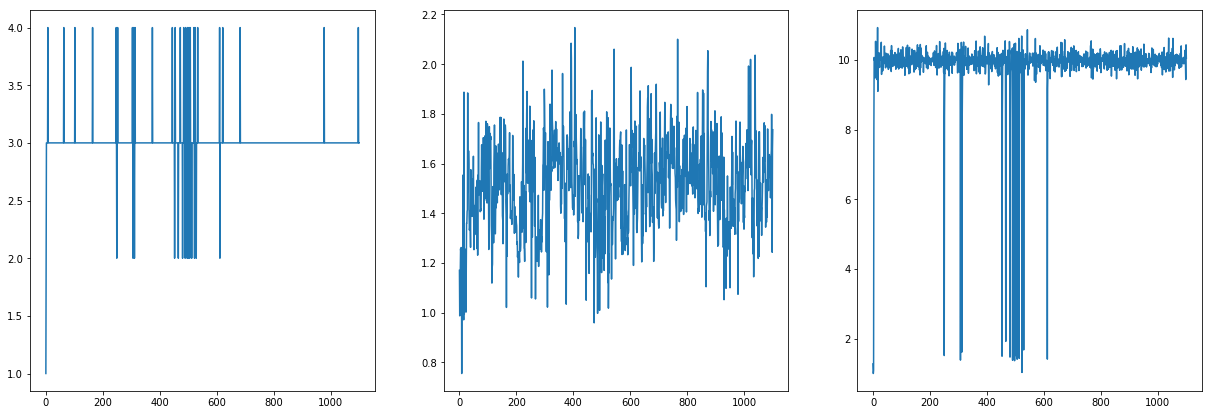

In [15]:
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
ax = plt.plot(qcount_panda_list)
plt.subplot(1,3,2)
ax = plt.plot(networktime_list)
plt.subplot(1,3,3)
ax = plt.plot(looptime_list)
print(gtimer)

# Test both

In [16]:
PANDA_NTIME_REF = 3e-3
Q0_panda = panda.get_qcur()

[ 0.         -0.         -0.          0.         -0.          0.
 -0.99004225 -1.16020587 -0.09935153 -1.08413537  0.28192717  1.8495644
 -2.16893122]
[ 0.         -0.         -0.          0.         -0.          0.
 -0.99004225 -1.16020587 -0.09935153 -1.08413537  0.28192717  1.8495644
 -2.16893122]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


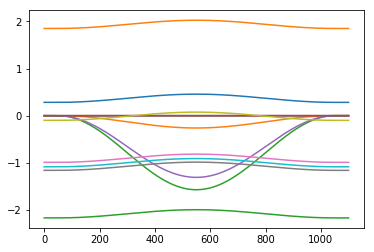

In [17]:
# Prepare path

N_t = 1000
PORT_REPEATER = 1189
indy_idx = np.arange(6)
panda_idx = np.arange(7)+6

MAG = 1#np.deg2rad(5)
e_POS_indy = np.deg2rad([[0, -15, -90, 0, -75, 0]])*np.transpose([MAG*((np.sin(np.pi*(np.arange(N_t+1)*2-N_t/2)/N_t)+1)/2)])
e_POS_indy = np.pad(e_POS_indy, [[50,50],[0,0]],'edge')
e_POS_panda = np.deg2rad([[10]*PANDA_DOF])*np.transpose([MAG*((np.sin(np.pi*(np.arange(N_t+1)*2-N_t/2)/N_t)+1)/2)])
e_POS_panda = Q0_panda+np.pad(e_POS_panda, [[50,50],[0,0]],'edge')
e_POS = np.concatenate([e_POS_indy, e_POS_panda], axis=1)

plt.plot(e_POS)
print(e_POS[0])
print(e_POS[-1])
print(e_POS[0]-e_POS[-1])

In [18]:
gtimer.reset()

indy.connect()
indy_joint_move_make_sure(indy, e_POS[0, indy_idx])
indy_init_online_tracking(indy, e_POS[0, indy_idx], TRAJECTORY_FREQ)
panda.reset()

qcount = 0
qcount_indy_list = []
qcount_panda_list = []
looptime_list = []
networktime_indy_list = []
networktime_panda_list = []
for Q in e_POS:
    gtimer.tic("loop")
    Q_indy = Q[indy_idx]#[0]*6
    Q_panda = Q[panda_idx]
    while(qcount>=3):
        qcount -= 1
        rate.sleep()
    gtimer.tic("send_recv_indy")
    qcount_indy=indy_send_track_q(indy, Q_indy)['qcount']    
    ntime_indy = gtimer.toc("send_recv_indy")
    time.sleep(max(0, PANDA_NTIME_REF-ntime_indy*1e-3))
    gtimer.tic("send_recv_panda")
    if qcount_panda>3:
        qcount_panda = panda.get_qcount()
    else:
        qcount_panda = panda.send_qval(Q_panda)['qcount']
    ntime_panda = gtimer.toc("send_recv_panda")
    networktime_panda_list.append(ntime_panda)
    networktime_indy_list.append(ntime_indy)
    qcount = qcount_indy
    qcount_indy_list.append(qcount_indy)
    qcount_panda_list.append(qcount_panda)
    looptime_list.append(gtimer.toc("loop"))
    
indy_stop_online_tracking(indy)
panda.stop_tracking()
indy.disconnect()

Connect: Server IP (192.168.0.63)


loop: 	10972.0 ms/1101 = 9.966 ms (4.44/11.597)
send_recv_indy: 	1470.0 ms/1101 = 1.336 ms (0.856/2.156)
send_recv_panda: 	1557.0 ms/1101 = 1.414 ms (0.744/2.433)



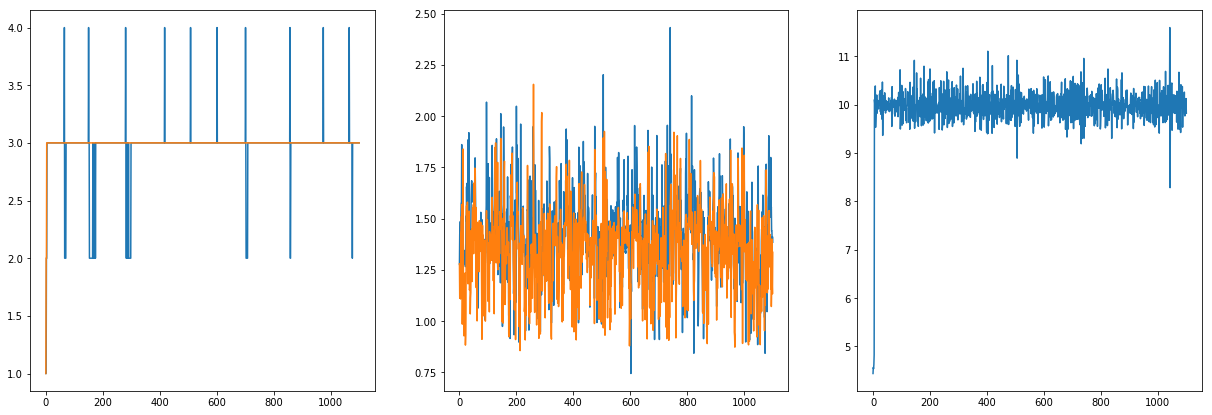

In [21]:
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
ax = plt.plot(qcount_panda_list)
ax = plt.plot(qcount_indy_list)
plt.subplot(1,3,2)
ax = plt.plot(networktime_panda_list)
ax = plt.plot(networktime_indy_list)
plt.subplot(1,3,3)
ax = plt.plot(looptime_list)
print(gtimer)